# 📣 Pronóstico de tasa de cancelación de clientes - Telecom

## 📌 Introducción
Al operador de telecomunicaciones Interconnect le gustaría poder pronosticar su tasa de cancelación de clientes. 
    
Si se descubre que un usuario o usuaria planea irse, se le ofrecerán códigos promocionales y opciones de planes especiales. 
 

## 🎯 Problema de negocio
La clientela puede elegir entre un pago mensual o firmar un contrato de 1 o 2 años. Puede utilizar varios métodos de pago y recibir una factura electrónica después de una transacción. Telecom necesita descubrir si un usuario o usuaria planea irse, para ofrecerle códigos promocionales y opciones de planes especiales. 


## 🔍 Objetivo del proyecto
✔ Preparar un *snapshot* al **01-feb-2020** y un dataset limpio para modelado donde la **clase positiva** sea **`stay = 1`** (cliente activo, `EndDate == "No"`).  


## Inicialización

In [1]:
# Cargar todas las librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import numpy as np

In [2]:
df_contract = pd.read_csv("./datasets/contract.csv")
df_personal = pd.read_csv("./datasets/personal.csv")
df_internet = pd.read_csv("./datasets/internet.csv")
df_phone    = pd.read_csv("./datasets/phone.csv")

## 📌 1. Descripción y preprocesamiento de los datos 

## 🎯 1.1  Contract

In [3]:
print('Dimensiones:', df_contract.shape)
print('\nTipos de datos:')
df_contract.info()


Dimensiones: (7043, 8)

Tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
df_contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


### 🧹 1.1.1 Convertir fechas a datetime

In [5]:
df_contract["BeginDate"] = pd.to_datetime(df_contract["BeginDate"])
df_contract["EndDate"]   = pd.to_datetime(df_contract["EndDate"], errors="coerce")  
df_contract["MonthlyCharges"] = pd.to_numeric(df_contract["MonthlyCharges"], errors="coerce")
df_contract["TotalCharges"]   = pd.to_numeric(df_contract["TotalCharges"],   errors="coerce")

C:\Users\jessi\AppData\Local\Temp\ipykernel_48460\3973930906.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_contract["EndDate"]   = pd.to_datetime(df_contract["EndDate"], errors="coerce")


### 🧹 1.1.2 Tenure al snapshot

In [6]:
snapshot = pd.Timestamp("2020-02-01")
df_contract["tenure_months"] = (((snapshot - df_contract["BeginDate"]).dt.days)
                             .clip(lower=0) / 30.44).round().astype(int)

### 🛑 1.1.3 Etiquetas

In [7]:
df_contract["churn"] = df_contract["EndDate"].notna().astype(int)   # 1 = se va
df_contract["stay"]  = df_contract["EndDate"].isna().astype(int)    # 1 = se queda (objetivo)

In [8]:
df_contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_months,churn,stay
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,1,0,1
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,34,0,1
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,4,1,0
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,45,0,1
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,5,1,0


## 🎯 1.2 Personal

In [9]:
print('Dimensiones:', df_personal.shape)
print('\nTipos de datos:')
df_personal.info()

Dimensiones: (7043, 5)

Tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
df_personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


## 🎯 1.3 Internet

In [11]:
print('Dimensiones:', df_internet.shape)
print('\nTipos de datos:')
df_internet.info()


Dimensiones: (5517, 8)

Tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [12]:
df_internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


## 🎯 1.4 Phone

In [13]:
print('Dimensiones:', df_phone.shape)
print('\nTipos de datos:')
df_phone.info()


Dimensiones: (6361, 2)

Tipos de datos:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [14]:
df_phone.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


## 🖇️ 1.5 Unión por costumerID

In [15]:
df = (df_contract
      .merge(df_personal, on="customerID", how="left")
      .merge(df_internet, on="customerID", how="left")
      .merge(df_phone,    on="customerID", how="left"))

In [16]:
df.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,tenure_months,churn,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,1,0,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,34,0,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,4,1,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,45,0,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,5,1,...,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,11,1,...,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,NaT,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,22,0,...,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,NaT,Month-to-month,No,Mailed check,29.75,301.90,10,0,...,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,31,1,...,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,NaT,One year,No,Bank transfer (automatic),56.15,3487.95,62,0,...,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   tenure_months     7043 non-null   int64         
 9   churn             7043 non-null   int64         
 10  stay              7043 non-null   int64         
 11  gender            7043 non-null   object        
 12  SeniorCitizen     7043 non-null   int64         
 13  Partner           7043 non-null   object        
 14  Dependents        7043 n

## 📍 1.6 Indicadores y ausencias de servicio

In [18]:
df["HasInternet"] = df["InternetService"].notna().astype(int)
df["HasPhone"]    = df["MultipleLines"].notna().astype(int)

internet_cols = ["InternetService","OnlineSecurity","OnlineBackup",
                 "DeviceProtection","TechSupport","StreamingTV","StreamingMovies"]
for col in internet_cols:
    df[col] = df[col].fillna("No")
df["MultipleLines"] = df["MultipleLines"].fillna("No")

## ✏️ 1.7 Normalización de categorías

In [19]:
n_cols = ["PaperlessBilling","Partner","Dependents"] + internet_cols + ["MultipleLines"]
for col in n_cols:
    if col in df:
        df[col] = (df[col].astype(str).str.strip()
                 .replace({"No internet service":"No", "No phone service":"No"}))

In [20]:
# Imputación mínima
na_mask = df["TotalCharges"].isna()
df.loc[na_mask, "TotalCharges"] = (df.loc[na_mask, "MonthlyCharges"] * df.loc[na_mask, "tenure_months"]).round(2)


In [21]:
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
print("Nulos antes:", df["TotalCharges"].isna().sum())

na_mask = df["TotalCharges"].isna()
df.loc[na_mask, "TotalCharges"] = (df.loc[na_mask, "MonthlyCharges"] * df.loc[na_mask, "tenure_months"]).round(2)

print("Nulos después:", df["TotalCharges"].isna().sum())  # debería ser 0


Nulos antes: 0
Nulos después: 0


In [22]:
# Selección de columnas
df_keep = ["customerID","stay","churn","MonthlyCharges","TotalCharges","tenure_months",
        "Type","PaperlessBilling","PaymentMethod","gender","SeniorCitizen","Partner","Dependents",
        "HasInternet","HasPhone","InternetService","OnlineSecurity","OnlineBackup",
        "DeviceProtection","TechSupport","StreamingTV","StreamingMovies","MultipleLines"]


In [23]:
df_model = df[df_keep].copy()

print("Shape final:", df_model.shape)
print("Proporción stay:", round(df_model["stay"].mean(), 4))
print("Proporción churn:", round(df_model["churn"].mean(), 4))
display(df_model.head())


Shape final: (7043, 23)
Proporción stay: 0.7346
Proporción churn: 0.2654


,customerID,stay,churn,MonthlyCharges,TotalCharges,tenure_months,Type,PaperlessBilling,PaymentMethod,gender,...,HasInternet,HasPhone,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,1,0,29.85,29.85,1,Month-to-month,Yes,Electronic check,Female,...,1,0,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,1,0,56.95,1889.50,34,One year,No,Mailed check,Male,...,1,1,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,0,1,53.85,108.15,4,Month-to-month,Yes,Mailed check,Male,...,1,1,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,1,0,42.30,1840.75,45,One year,No,Bank transfer (automatic),Male,...,1,0,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,0,1,70.70,151.65,5,Month-to-month,Yes,Electronic check,Female,...,1,1,Fiber optic,No,No,No,No,No,No,No


In [24]:
clean_csv = "data_clean.csv"
df_model.to_csv(clean_csv, index=False)
print(f"Archivo guardado: {clean_csv}")

Archivo guardado: data_clean.csv


## 📌 2. EDA

In [25]:
(df_model.isna().sum()
 .sort_values(ascending=False)
 .to_frame("nulos"))

,nulos
customerID,0
stay,0
churn,0
MonthlyCharges,0
TotalCharges,0
tenure_months,0
Type,0
PaperlessBilling,0
PaymentMethod,0
gender,0


## 2.1 🔒 Stay Rate

In [26]:
for col in ["Type","PaymentMethod","InternetService","OnlineSecurity","TechSupport","MultipleLines"]:
    print(f"\n>>> {col}")
    display((df_model.groupby(col)["stay"]
             .mean()
             .sort_values(ascending=False)
             .round(3)
             .to_frame("stay_rate")))


>>> Type


,stay_rate
Type,
Two year,0.972
One year,0.887
Month-to-month,0.573



>>> PaymentMethod


,stay_rate
PaymentMethod,
Credit card (automatic),0.848
Bank transfer (automatic),0.833
Mailed check,0.809
Electronic check,0.547



>>> InternetService


,stay_rate
InternetService,
No,0.926
DSL,0.810
Fiber optic,0.581



>>> OnlineSecurity


,stay_rate
OnlineSecurity,
Yes,0.854
No,0.687



>>> TechSupport


,stay_rate
TechSupport,
Yes,0.848
No,0.688



>>> MultipleLines


,stay_rate
MultipleLines,
No,0.750
Yes,0.714


## 📊 2.2 Gráficos

### 2.2.1 Distribuciones

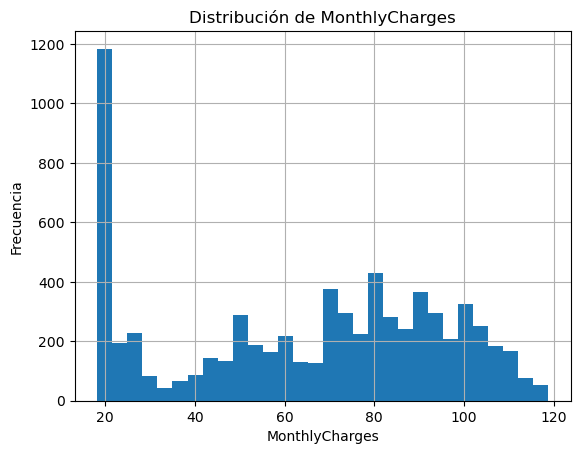

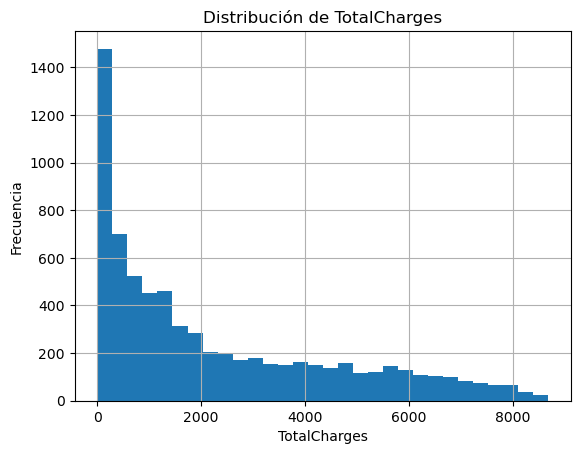

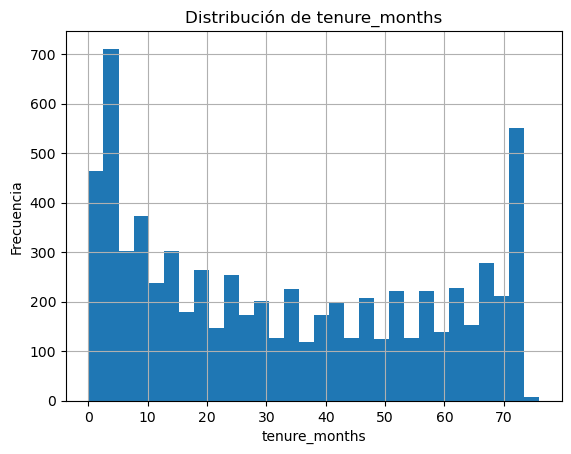

In [27]:
for col in ["MonthlyCharges","TotalCharges","tenure_months"]:
    plt.figure()
    df_model[col].dropna().hist(bins=30)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col); plt.ylabel("Frecuencia")
    plt.show()

#### Conclusiones

1) MonthlyCharges

La distribución muestra que, a medida que la factura mensual sube, es más común que la permanencia baje.

Sugerencia: vigilar aumentos de precio y ofrecer planes escalonados o beneficios a quienes pagan más.

2) TotalCharges

En la distribución se puede ver que los clientes con un alto acumulado tienden a seguir con la empresa, lo que prueba que cuanto más tiempo dentro, más se estabiliza la relación.

Sugerencia: cuidar la experiencia temprana porque, una vez superada la etapa inicial, la permanencia mejora sola.

3) tenure_months 

Se puede observar que los clientes que se quedan se agrupan en antigüedades medias y altas, mientras que quienes se van se concentran en los primeros meses.

Sugerencia: dar seguimiento en los primeros meses.


### 2.2.2 Tasa de clientes que se quedan

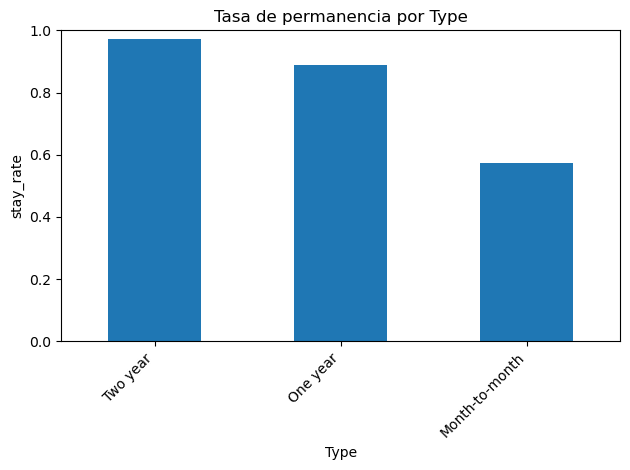

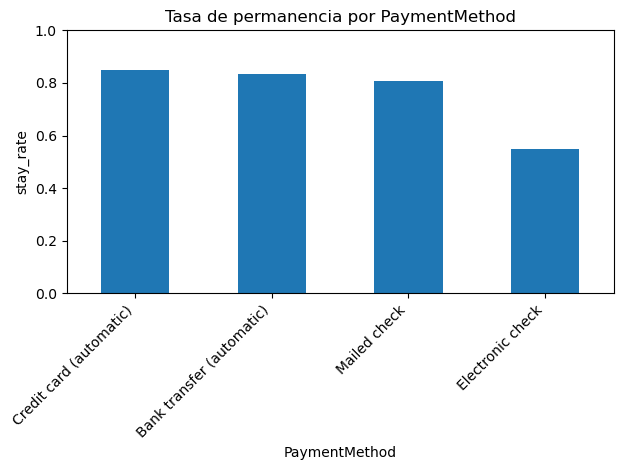

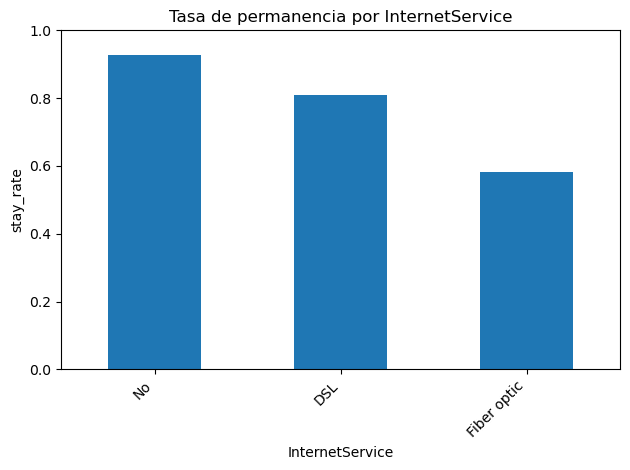

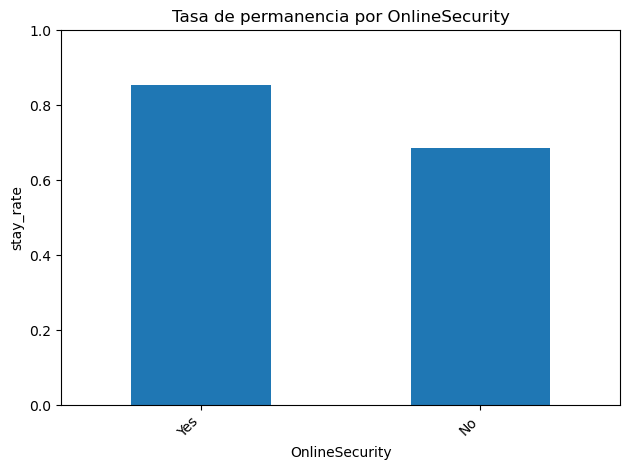

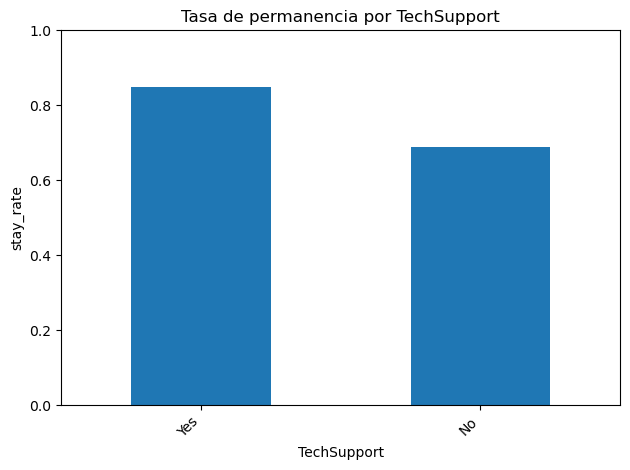

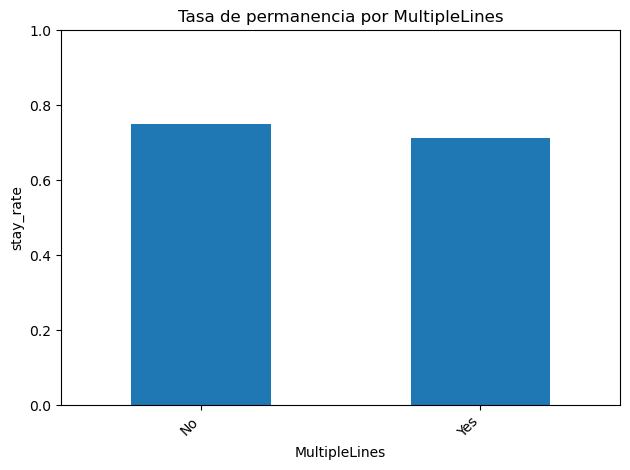

In [28]:

def bar_rate(df, cat_col, target='stay'):
    rates = (df.groupby(cat_col)[target].mean().sort_values(ascending=False))
    plt.figure()
    rates.plot(kind="bar")
    plt.title(f"Tasa de permanencia por {cat_col}")
    plt.ylabel(f"{target}_rate"); plt.xlabel(cat_col)
    plt.ylim(0, 1); plt.xticks(rotation=45, ha="right")
    plt.tight_layout(); plt.show()

for col in ["Type","PaymentMethod","InternetService","OnlineSecurity","TechSupport","MultipleLines"]:
    bar_rate(df_model, col, target="stay")

#### Conclusiones

1) Type (tipo de contrato)

En el gráfico se muestra que el contrato mensual es el segmento de mayor riesgo; los contratos anuales y bienales retienen mucho mejor.

Sugerencia: ofrecer un incentivo para la retención de los clientes.

2) PaymentMethod

Se puede observar que los métodos automáticos se asocian con mejor retención.

Sugerencia: Activar débito/autopay con un incentivo.

4) InternetService

Dentro de los clientes que tienen internet, fiber optic retiene peor que DSL. Esto probablemente se deba al precio y competencia de ese segmento. 

Sugerencia: Revisar la relación pricing-beneficios para fiber optic y comunicar el valor que lo distingue.

5) OnlineSecurity

Contar con seguridad online se asocia a más permanencia. 

Sugerencia: empaquetar la seguridad como beneficio de fidelidad y facilitar su adopción en clientes de riesgo.

6) TechSupport

Tener soporte técnico también coincide con mayor permanencia.

Sugerencia: mantener un contacto proactivo con clientes de alto riesgo (sin soporte contratado)

7) MultipleLines

La señal es más tenue: no parece un driver principal por sí solo.

### 2.3 Cargos mensuales por servicio

C:\Users\jessi\AppData\Local\Temp\ipykernel_48460\3992201053.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=cats, showmeans=True)


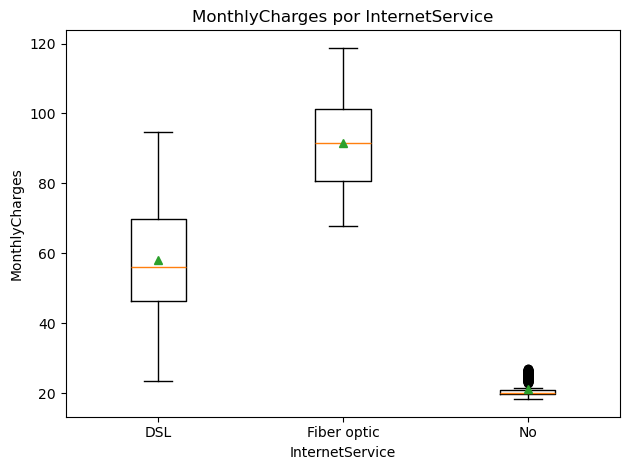

In [29]:
cats = [c for c in df_model["InternetService"].dropna().unique().tolist()]
data = [df_model.loc[df_model["InternetService"]==c, "MonthlyCharges"].dropna().values for c in cats]
plt.figure()
plt.boxplot(data, labels=cats, showmeans=True)
plt.title("MonthlyCharges por InternetService")
plt.xlabel("InternetService"); plt.ylabel("MonthlyCharges")
plt.tight_layout(); plt.show()

#### Conclusiones

Fiber optic aparece con las facturas mensuales más altas; DSL significativamente más bajo; sin internet, muy bajo. Esto conecta con lo visto anteriormente: precio alto + fibra = mayor riesgo. 


### 2.5 Matriz de correlación

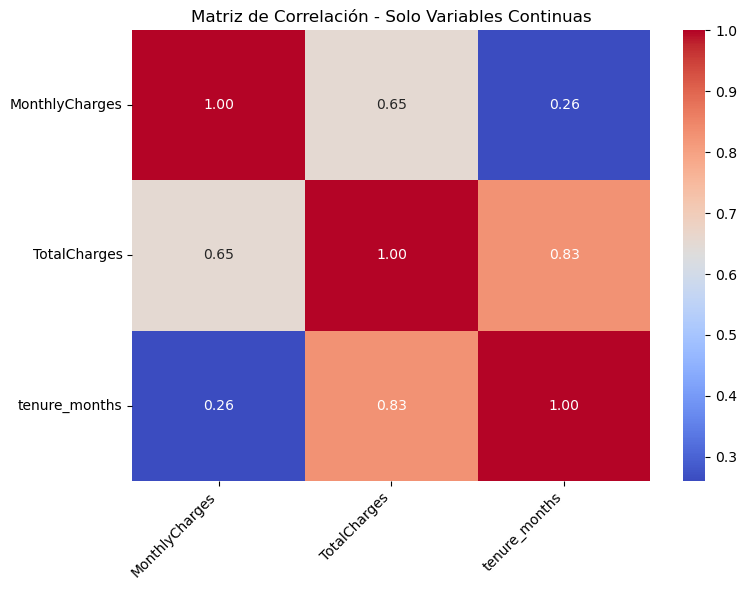

In [30]:
# Paso 1: Seleccionar columnas numéricas
num_df = df_model.select_dtypes(include=["int64", "float64"])

# Paso 2: Identificar columnas binarias (solo contienen 0 y 1)
binary_cols = [col for col in num_df.columns 
               if set(num_df[col].dropna().unique()) <= {0, 1}]

# Paso 3: Excluir columnas binarias
continuous_cols = [col for col in num_df.columns if col not in binary_cols]

# Paso 4: Calcular la matriz de correlación solo con variables continuas
corr_matrix = df_model[continuous_cols].corr()

# Paso 5: Visualizar
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación - Solo Variables Continuas")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

#### Conclusiones

La señal dominante de permanencia es la antigüedad; después pesan variables ligadas a costo y a tener internet. También se observa una leve relación negativa con SeniorCitizen, que conviene monitorear por equidad.


## ⚙️ Plan de análisis

### Paso 1: Integración y limpieza
✔ Unir `contract`, `personal`, `internet` y `phone` por `customerID`
✔ Conversión de tipos de datos y fechas  
✔ Calcular `tenure_months` al 01-feb-2020
✔ Normalizar categorías (Yes/No)
✔ Crear las etiquetas `stay` (objetivo) y `churn` (referencia)

### Paso 2: EDA y chequeos de consistencia
✔ Explorar nulos, distribuciones y tasas de **stay** por segmento   
✔ Verificar coherencia entre `HasInternet/HasPhone` y las columnas asociadas
✔ Crear gráficos para visualización de datos

### Paso 3: Preparación de features y partición
✔ Definir variables numéricas/categóricas, aplicar One-Hot a categóricas y escalado a numéricas con `ColumnTransformer`  
✔ Hacer `train/test` (temporal o estratificado)  
✔ Preparar estrategia ante desbalance (si aplica)

### Paso 4: Modelado baseline y evaluación
✔ Entrenar modelos base y evaluar con **AUC-ROC** (principal) y **Accuracy** (adicional) usando la probabilidad de la clase **1 = stay* 

## Paso 5: Entrega
✔ Generar un csv limpio, guardar notebook reproducible y un breve reporte con métricas y hallazgos

✔ Definir mejoras y plan de monitoreo


## ❓ Preguntas clave

### 1) Negocio y objetivo
- **Población objetivo:** ¿Modelamos a **todos** los clientes o solo a quienes cumplan cierta antigüedad/plan?
- **Política de recontacto:** ¿Cada cuánto se reintenta a un mismo cliente?

### 2) Datos y etiqueta
- **Definición de stay/churn:** ¿EndDate = "No" ≡ contrato realmente activo? ¿Existen suspensiones?
- **Unidad de análisis:** ¿Cliente individual, cuenta/hogar o línea?
- **Churn parcial:** Si cancela internet pero conserva phone (o viceversa), ¿cómo se etiqueta?
- **Corte temporal:** ¿Todas las variables se toman al **01-feb-2020** (sin fugas)?
- **Promos previas:** ¿Existen variables de campañas pasadas que puedan introducir fuga?

### 3) Métricas y validación
- **Desbalance:** ¿class_weight u oversampling? (que no distorsione la evaluación)
- **Métricas por segmento:** ¿Reportamos por contrato, método de pago, senioridad, etc.?

### 4) Features e ingeniería
- **Variables sensibles:** ¿`gender` solo para monitoreo de sesgo (no para decisión)?
- **Transformaciones:** One-hot para categóricas, escalado para numéricas, ¿outliers?
- **Faltantes:** ¿Aceptamos `TotalCharges = MonthlyCharges * tenure_months` o preferimos otra política?

### 5) Operación e intervención
- **Consumo del score:** ¿Batch diario/semanal? ¿Formato de entrega (CSV/API/Dashboard)?
- **Umbral:** Aunque la rúbrica use AUC-ROC, ¿qué *threshold* se aplicará en producción?
- **Medición:** ¿Habrá grupo de control/AB test? 
